In [7]:
import os
os.chdir("/home/gosse/WorkSyncs/Code/perspective-transfer")

import pandas as pd
import seaborn as sns

In [25]:
sentences_to_scores = {}
for sentence_file in [
    "output/preproc/silver.full.filtered.jsonl",
    "output/preproc/gold.full.jsonl"]:

    sentences_df = pd.read_json(sentence_file, orient="records", lines=True)
    for entry in sentences_df.itertuples():
        sentence = entry.sentence
        perception_blame_murderer = entry.perception["B:suspect"]
        sentences_to_scores[sentence] = perception_blame_murderer


distances = []
mislabeled_low = set()
mislabeled_high = set()
align_pairs = pd.read_json("output/align/alignments.gold-silver.bm.2022-10-14.combinations.jsonl", orient="records", lines=True)
for pair in align_pairs.itertuples():
    sentence_low = pair.sentence_low
    sentence_high = pair.sentence_high
    score_low = sentences_to_scores[sentence_low]
    score_high = sentences_to_scores[sentence_high]
    diff = score_high - score_low

    # for some reason, a few samples got mislabeled (during the alignment process?)
    if score_low > 0:
        mislabeled_low.add(sentence_low)
        continue
    if score_high < 0:
        mislabeled_high.add(sentence_high)
        continue

    distances.append({
        "event": pair.event,
        "sentence_low": sentence_low,
        "sentence_high": sentence_high,
        "score_low": score_low,
        "score_high": score_high,
        "diff": diff
    })
distances_df = pd.DataFrame(distances)
print(len(mislabeled_high))
print(len(mislabeled_low))

4
4


In [26]:
distances_df.head()

,event,sentence_low,sentence_high,score_low,score_high,diff
0,400,Per spiegare il suo gesto ha detto che la mogl...,"Questa volta , però , il tentativo dell'uomo d...",-0.453196,0.471155,0.924351
1,400,Per spiegare il suo gesto ha detto che la mogl...,"L ’ uomo ha spiegato , inoltre , che aveva il ...",-0.453196,0.021238,0.474434
2,400,Per spiegare il suo gesto ha detto che la mogl...,"Un uomo di 79 anni , Antonio Parisi , ha stran...",-0.453196,0.935759,1.388955
3,400,Per spiegare il suo gesto ha detto che la mogl...,L ’ anziano aveva anche preparato il bagaglio ...,-0.453196,0.292132,0.745328
4,400,Per spiegare il suo gesto ha detto che la mogl...,Ha strangolato la moglie con un filo elettrico...,-0.453196,0.661151,1.114346


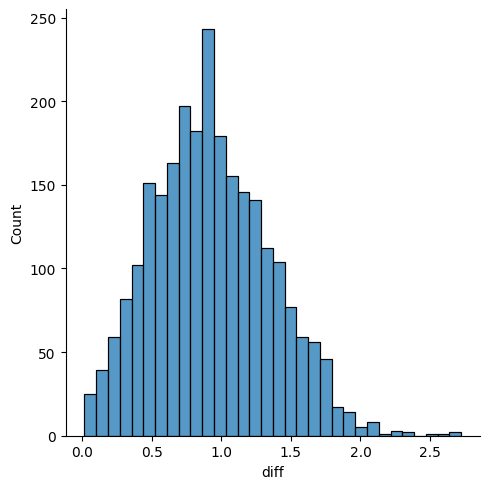

In [24]:
sns.displot(distances_df["diff"])

In [59]:
sorted_diff_events = (
    distances_df
    .groupby("event")
    .agg(**{"diff": ("diff", "mean"), "size": ("diff", "size")})
    .sample(frac=1, random_state=1996)
    .reset_index()
)
sorted_diff_events

,event,diff,size
0,564,1.262846,2
1,581,0.683763,12
2,519,0.835719,145
3,463,1.167745,72
4,513,0.993665,13
...,...,...,...
59,407,0.775744,5
60,612,1.961034,1
61,544,1.666595,3
62,402,1.135950,7


In [60]:
first_250 = sorted_diff_events[sorted_diff_events["size"].cumsum() > 250].index[0]
first_250

5

In [68]:
events = sorted_diff_events.iloc[:5 + 1]["event"].tolist()
events 

[564, 581, 519, 463, 513, 568]

In [69]:
distances_df[distances_df["event"].isin(events)]

,event,sentence_low,sentence_high,score_low,score_high,diff
227,463,"« Come vuole che ci si senta , quando ci sono ...","Albenga , uccide l ' ex compagna a coltellate ...",-1.051126,0.754413,1.805539
228,463,"« Come vuole che ci si senta , quando ci sono ...","Albenga , stalker arrestato e scarcerato uccid...",-1.051126,1.094997,2.146122
229,463,"« Come vuole che ci si senta , quando ci sono ...","Albenga , lite tra ex : due morti in casa",-1.051126,0.209047,1.260173
230,463,"« Come vuole che ci si senta , quando ci sono ...","Tutto si è svolto oggi , in pochi minuti , in ...",-1.051126,0.251070,1.302195
231,463,"« Come vuole che ci si senta , quando ci sono ...",Loredana e l'ex marito sono morti a causa di f...,-1.051126,0.369462,1.420587
...,...,...,...,...,...,...
2337,581,« Sì sono stato io ad uccidere mia madre - ha ...,« L'ho uccisa perchè non voleva rivelarmi chi ...,-0.192569,0.152666,0.345235
2338,581,« Sì sono stato io ad uccidere mia madre - ha ...,« L'ho uccisa perchè non voleva rivelarmi chi ...,-0.192569,0.152666,0.345235
2339,581,Non solo : per essere sicuro che la mamma non ...,E ' stato arrestato dalla polizia il figlio di...,-0.451606,0.059870,0.511477
2340,581,Non solo : per essere sicuro che la mamma non ...,« L'ho uccisa perchè non voleva rivelarmi chi ...,-0.451606,0.152666,0.604273
